In [5]:
import sys
sys.path.append('..')
from pathlib import Path
from datetime import datetime
from dateutil import tz

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from metpy.plots.ctables import registry
from siphon.catalog import TDSCatalog
import xarray as xr

from Map import Map

In [ ]:
LOCATION = 'southeast'

In [6]:
# Scan the catalog and download the data

def get_satellite():
    satcat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
                        'CloudAndMoistureImagery/CONUS/Channel08/current/catalog.xml')
    dataset = satcat.datasets[0]
    dataset = dataset.remote_access(use_xarray=True)
    return dataset

ds = get_satellite()

In [7]:
# Parse out the projection data from the satellite file
data = ds.metpy.parse_cf('Sectorized_CMI')
proj = data.metpy.cartopy_crs
x = data['x']
y = data['y']

def convert_datetime(mrms_time):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New York')
    utc_time = datetime.strptime(mrms_time, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

VALID_TIME = convert_datetime(str(data['time'].values).split('.')[0])

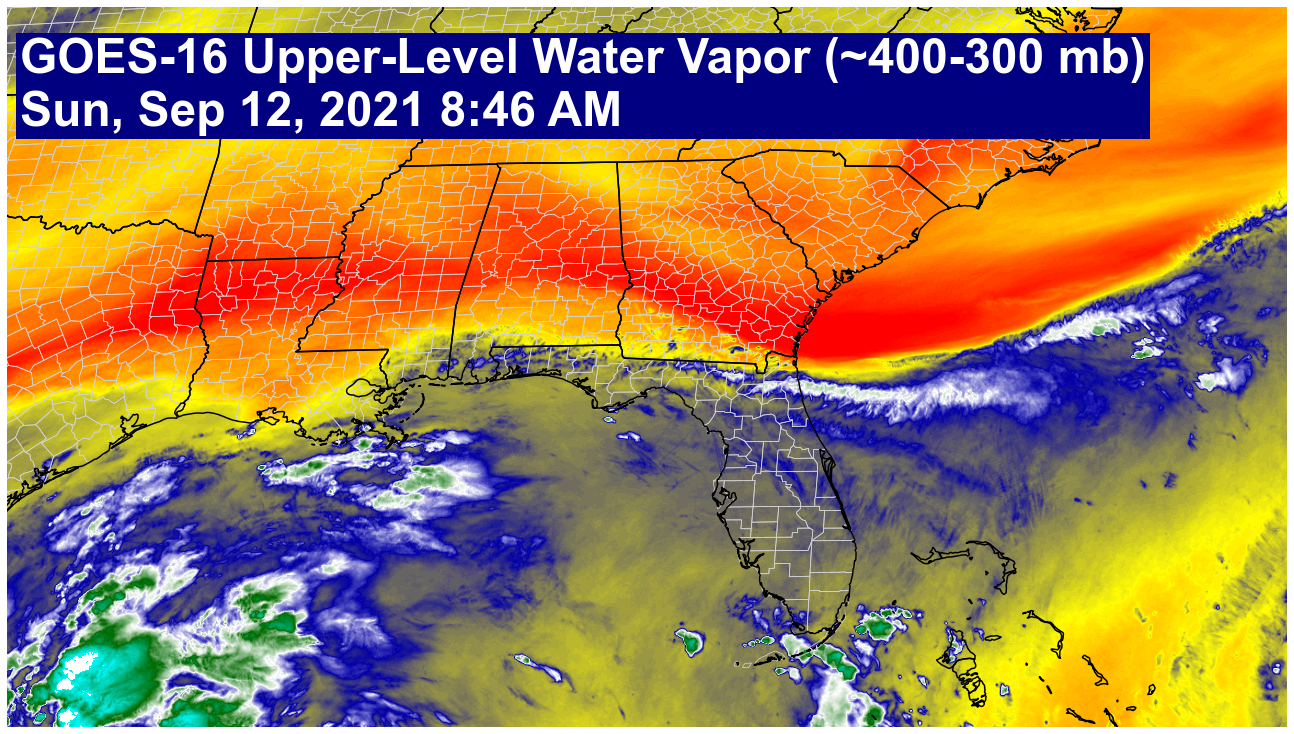

In [12]:
def plot_satellite():
    new_map = Map(LOCATION, proj)
    new_map.add_counties()
    new_map.add_title(f'GOES-16 Upper-Level Water Vapor (~400-300 mb)\n{VALID_TIME}')

    fig, ax = new_map.make_map()

    norm, cmap = registry.get_with_range('WVCIMSS_r', 200, 250)

    im = ax.imshow(data, extent=(x.min(), x.max(), y.min(), y.max()),
                   origin='upper')
    im.set_cmap(cmap)
    im.set_norm(norm)
    

# Save and show figure
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'satellite'
fig.savefig(f'{graphics_dir}/wv_upper.png', dpi=72)
fig